In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [191]:
df = pd.read_csv("processed_data.csv")
df = df.dropna(axis=0)
# y = df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]
y = df["vocabulary"]
X = df.iloc[:, 7:]
X = X.drop("corrected_text", axis=1)
X["text_standard"].mask(df["text_standard"] == "-", 0, inplace=True)
X["verb_to_adv"].mask(np.isinf(df["verb_to_adv"]), 0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

In [192]:
pd.set_option("display.max_columns", None)
X_train.describe()
# X_train.columns.values

,number_of_words,stopwords_frequency,av_word_per_sen,punctuations,ARI,freq_of_verb,freq_of_adj,freq_of_adv,freq_of_distinct_adj,freq_of_distinct_adv,sentence_complexity,freq_of_wrong_words,sentiment_compound,sentiment_positive,sentiment_negative,num_of_grammar_errors,num_of_short_forms,Incorrect_form_ratio,flesch_reading_ease,flesch_kincaid_grade,dale_chall_readability_score,text_standard,mcalpine_eflaw,number_of_diff_words,freq_diff_words,ttr,coherence_score,lexrank_avg_min_diff,lexrank_interquartile,freq_of_noun,freq_of_transition,freq_of_pronoun,noun_to_adj,verb_to_adv,phrase_diversity
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,432.713945,0.502049,30.168956,0.070660,13.602796,0.105502,0.090875,0.040801,0.058655,0.021390,1.532348,0.017157,0.722224,0.154601,0.058401,26.028640,0.033754,0.063163,65.192138,11.538595,6.619755,10.519605,-17.382100,43.673031,0.104082,0.073049,0.438264,0.471963,0.446591,0.251382,0.043381,0.091391,0.372425,0.411660,0.154776
std,193.729433,0.051186,27.545586,0.024683,13.557621,0.025703,0.022454,0.016351,0.015704,0.009059,0.068771,0.016299,0.604401,0.067630,0.043952,18.882161,0.296442,0.037794,27.401161,10.409668,1.593507,7.184903,39.320372,21.265115,0.032861,0.015238,0.098933,0.190629,0.246988,0.044987,0.014912,0.032314,0.112219,0.217131,0.093385
min,51.000000,0.000000,6.344828,0.000000,1.000000,0.004706,0.010471,0.003922,0.005236,0.000000,1.176139,0.000000,-0.998600,0.000000,0.000000,0.000000,0.000000,0.000000,-489.820000,1.600000,1.090000,0.000000,-832.000000,3.000000,0.028078,0.029574,0.176278,0.000000,0.000000,0.112994,0.002488,0.004963,0.031250,0.034483,0.002232
25%,295.000000,0.469101,18.347826,0.054010,8.000000,0.088362,0.076316,0.029345,0.047847,0.015152,1.489412,0.006522,0.921100,0.107000,0.025000,14.000000,0.000000,0.037175,59.840000,7.100000,6.020000,7.000000,-21.300000,29.000000,0.080386,0.062757,0.375084,0.346772,0.266950,0.219684,0.033074,0.068602,0.295775,0.275000,0.089947
50%,404.000000,0.502222,23.083333,0.070000,10.000000,0.104558,0.089721,0.039152,0.057325,0.020408,1.532959,0.012158,0.989100,0.147000,0.049000,21.000000,0.000000,0.054131,70.160000,9.100000,6.470000,9.000000,-7.300000,40.000000,0.100478,0.072128,0.421990,0.494967,0.425602,0.250965,0.042591,0.089928,0.360000,0.383333,0.136432
75%,529.000000,0.536193,33.125000,0.086735,15.000000,0.121457,0.104478,0.051075,0.067925,0.026477,1.578315,0.022876,0.996500,0.195000,0.082000,32.000000,0.000000,0.080402,77.770000,12.700000,7.050000,11.000000,-0.500000,55.000000,0.123288,0.082317,0.478245,0.612647,0.600006,0.279412,0.052529,0.112583,0.433333,0.506849,0.199471
max,1260.000000,0.665227,578.000000,0.164835,287.000000,0.220513,0.203233,0.127049,0.130137,0.072816,1.804454,0.207207,0.999900,0.473000,0.312000,294.000000,7.000000,0.515789,102.000000,225.200000,33.320000,120.000000,15.200000,172.000000,0.272189,0.143911,1.000000,0.896260,1.613200,0.538824,0.148718,0.214953,1.086420,5.000000,0.861702


In [193]:
# round the prediction to the nearest 0.5 floor
def half_floor(prediction):
    adj_prediction = []
    for num in prediction:
        num = round(num * 2) / 2
        adj_prediction.append(num)
    return adj_prediction
# accurancy rate
def score(pred, test):
    correct = 0
    for i in range(len(test)):
        p = pred[i]
        t = test[i]
        if p == t:
            correct += 1
    return correct / len(test)


In [194]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# print(lr.score(X_test, y_test))
prediction = lr.predict(X_test)
# make prediction to the nearest 0.5 level
adj_prediction = half_floor(prediction)
score(adj_prediction, np.array(y_test))

0.4222903885480573

In [195]:
import pickle
pickle.dump(lr, open('lr.sav', 'wb'))

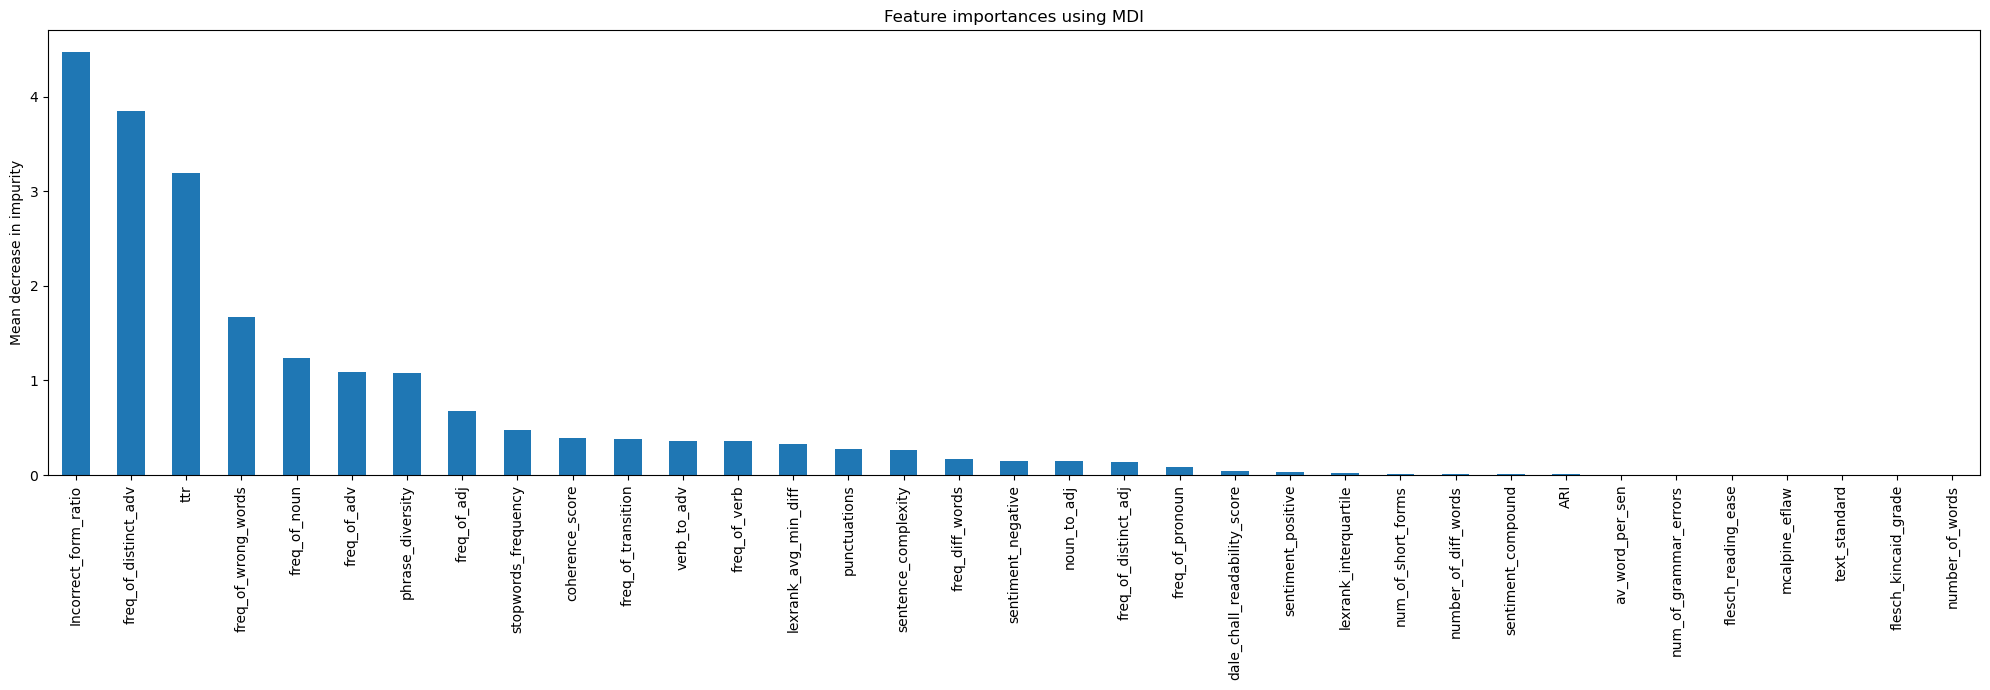

In [196]:
# Feature Importance using MDI
import matplotlib.pyplot as plt
importances = abs(lr.coef_)

forest_importances = pd.Series(importances, index=X_test.columns.values.tolist()).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20,7))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Using the prediction of vocab to train the model for cohesion

In [197]:
new_feature = lr.predict(X)
vocab = pd.Series(new_feature)
features = X.loc[:]
features["vocab"] = vocab

In [198]:
target = y = df["cohesion"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target, test_size=1/4)

In [199]:
new_lr = LinearRegression()
new_lr.fit(X_train2, y_train2)
prediction2 = new_lr.predict(X_test2)
# make prediction to the nearest 0.5 level
adj_prediction2 = half_floor(prediction2)
score(adj_prediction2, np.array(y_test2))


0.33844580777096117

In [10]:
pickle.dump(new_lr, open('lr_second.sav', 'wb'))